# Imports\


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [1]:
# !export GPN_DB_HOST=192.168.10.36


In [2]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')



2023-02-04 12:41:58.150494: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-02-04 12:42:00,690 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


### Prepare workdir

In [7]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


### Query DB for contact IDs

#### Load meta data CSV

In [ ]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [ ]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [11]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'
stats

lastdate=2023-02-04 11:02:49.897000+00:00 ; export_fn=/root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63dccb422c90db0b7a62aaa0,db,0fd8c821da37f3fa8e44c53767fb7842,23.01.23,2023-02-04 11:26:26.620470,1398.0,2023-02-03 12:45:55.389000+00:00,NaN,NaN,NaN,рублей,...,Займодавец,ИТО,Заемщик,Loans,0.811065,NaT,True,CONTRACT,84.0,12.0
63dccb3f2c90db0b7a62aa4f,db,63eb26415678c8e225543264d981d460,23.01.23,2023-02-04 11:26:26.670686,422.0,2023-02-03 12:46:57.294000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Канарейка,NaN,Other,0.961689,NaT,False,SUPPLEMENTARY_AGREEMENT,1.0,2.0
63dccb3f2c90db0b7a62aa5d,db,5b8260ef4f47dfb261a3ee74193fc576,23.01.23,2023-02-04 11:26:26.675975,432.0,2023-02-03 12:47:14.155000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Канарейка,NaN,Other,0.961693,NaT,False,SUPPLEMENTARY_AGREEMENT,1.0,3.0
63dccb402c90db0b7a62aa77,db,94bb8a85bfb0d2168a144ec23aa7e99b,23.01.23,2023-02-04 11:26:26.684980,360.0,2023-02-03 12:47:53.920000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Союз,Заемщик,Other,0.857242,NaT,False,SUPPLEMENTARY_AGREEMENT,1.0,1.0


# functions

In [12]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)
    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in jd.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
add_stats_record(jd, stats)
stats.loc['5fe34f62b770574a005553be']

DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

source                                                db
checksum                da2dd54cdcc5b4480207c9def7741d14
version                                           2.3.13
export_date                   2023-02-04 12:47:16.776299
len                                                  759
analyze_date            2020-12-23 17:14:16.727000+00:00
value                                           1.64e+06
value_log1p                                      14.3102
value_span                                           128
currency                                             RUB
org-1-name                        Газпромнефть-Снабжение
org-1-alias                               Благотворитель
org-2-name                           инициатив «Эпсилон»
org-2-alias                              Благополучатель
subject                                          Charity
subject confidence                                     1
user_correction_date    2022-12-08 19:07:01.522000+00:00
valid                          

# load old json

In [13]:
import json
import re
from bson import json_util

_DEBUG = False
file_data=None

try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7f4f95dffeb0>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

semantic_map_keys ['amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit']
semantic_map_keys ['org-name', 'org-alias', 'org-type']
semantic_map_keys all ['headline', 'subject', 'date', 'number', 'org-name', 'org-alias', 'org-type', 'amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']
semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


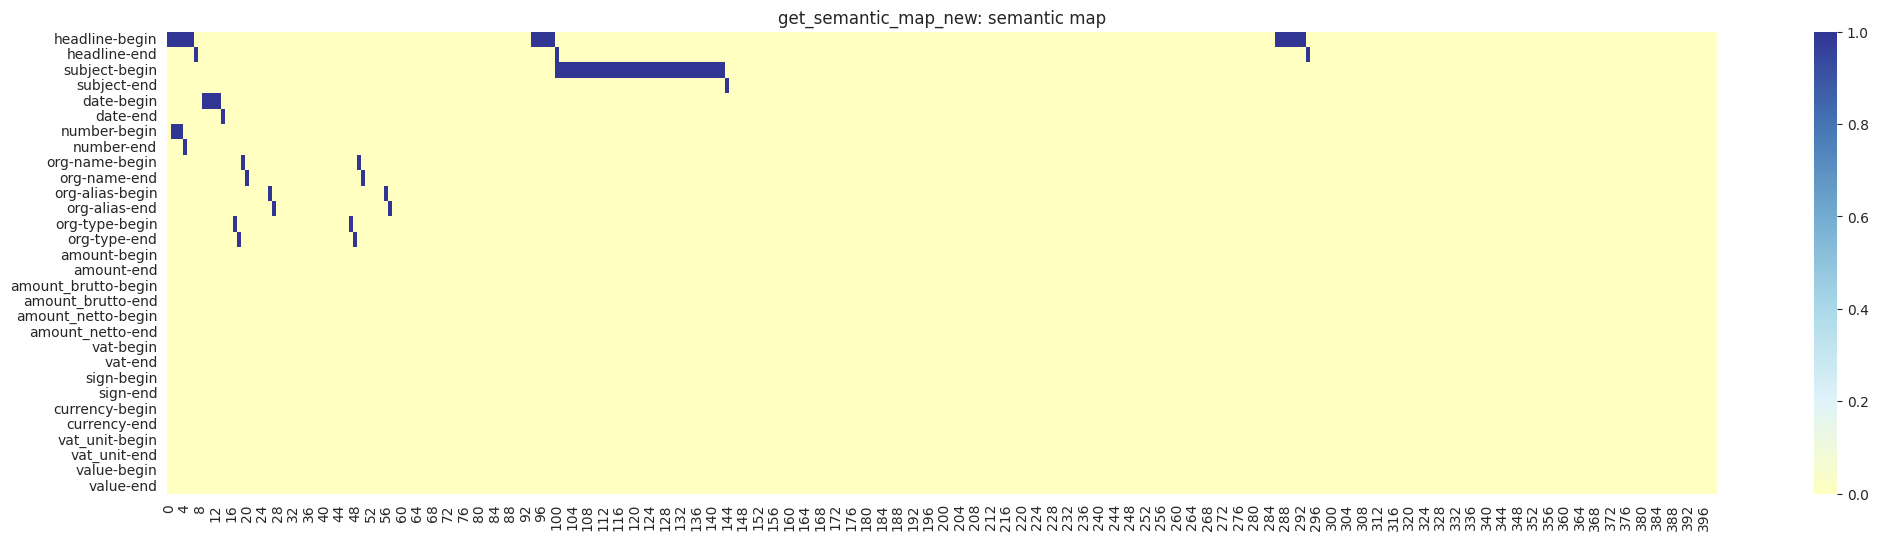

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [15]:


semantic_map_keys = [
    'headline',
    'subject', 
    'date', 
    'number',
    'org-name', 
    'org-alias', 
    'org-type'
]

semantic_map_keys += ['amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']

semantic_map_keys_contract = []
for _name in semantic_map_keys:
    semantic_map_keys_contract.append(_name + "-begin")
    semantic_map_keys_contract.append(_name + "-end")

print("semantic_map_keys", semantic_map_keys[8:14])
print("semantic_map_keys", semantic_map_keys[4:7])
print("semantic_map_keys all", semantic_map_keys)
print("semantic_map_keys_contract", semantic_map_keys_contract)

def get_semantic_map_new(doc: DbJsonDoc):
    
    _len = len(doc)
    df = DataFrame()
    
    for sl in semantic_map_keys_contract:    
        df[sl] = np.zeros(_len)
    
    attr_tree = doc.get_attributes_tree()
    
    def get_av(name):
        if name in df:
            return df[name]
        else:
            av = np.zeros(_len, np.float)
            df[name] = av
            return av

            
    def add_span_vectors(_name, span):
#         print('add_span_vectors',span)
        bn = _name + "-begin"
        en = _name + "-end"
        b = get_av(bn)
        e = get_av(en)
        if not span is None:
            df[bn][ span[0]:span[1] ]=1.
            df[en][ span[1] ]=1.
 
        

    # Headers
    headers = doc.analysis['headers']
    for h in headers:
        add_span_vectors('headline', h['span'])
 
 
    for n in semantic_map_keys[1:4]:
        span = attr_tree.get(n, {}).get('span')
        add_span_vectors(n, span)

 
    for i in [1, 2]:
        for n in semantic_map_keys[4:7]:
            try:                
                _nm = n.replace('org-', f'')
                span = attr_tree['orgs'][i-1][_nm]['span']
                add_span_vectors(n, span)
            except Exception as e:
                logger.exception(e)
                print('ERROR (sp)', e, i, n,  _nm)
                if _DEBUG:
                    try:  
                        print(json.dumps( attr_tree['orgs'][i-1], sort_keys=True, indent=4))
                    except:
                        pass
                    print('ERROR', i, n, doc.get_id(), e, attr_tree.get('orgs', None))
 

    _value_tag = attr_tree.get('price', {})
    add_span_vectors("value", _value_tag.get('span'))
 
    if _value_tag is not None:
        amount = get_amount(attr_tree) 
        if amount:
            add_span_vectors('amount', amount.get('span'))
        for n in semantic_map_keys[8:14]:
            add_span_vectors(n, _value_tag.get(n,{}).get('span'))
           
    return df[semantic_map_keys_contract]



if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:400], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

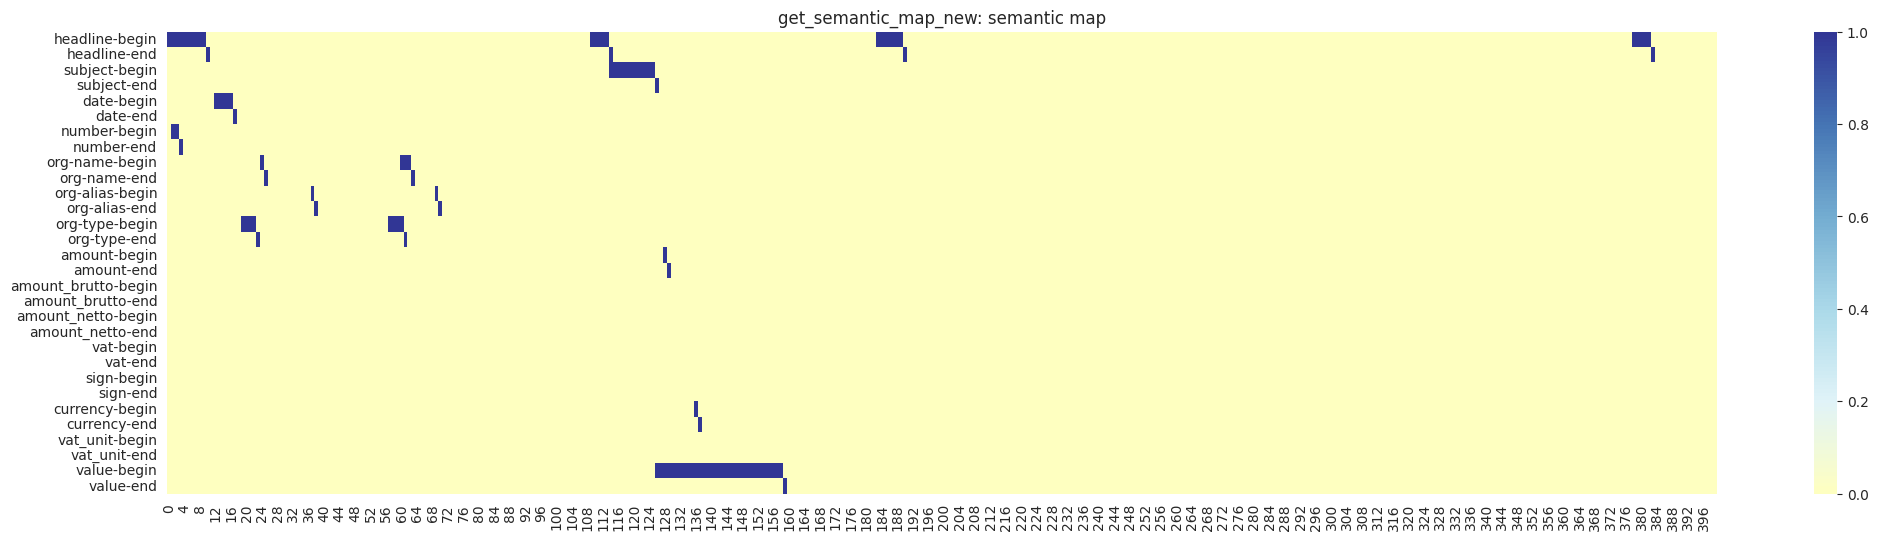

In [17]:
#test one

d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
if d is not None:
    jd = DbJsonDoc(d)
    semantic_map: DataFrame = get_semantic_map_new(jd)


    plot_embedding(semantic_map[0:400], f'get_semantic_map_new: semantic map')

### Adding data from old json file to the stats table

In [ ]:
# fff
files_dict = {}

if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
            
stats.to_csv(export_fn, index=True)
stats.to_csv('tmp.csv', index=True)

print(f'stats saved to {export_fn}')

# del file_data
stats




In [18]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers


In [21]:
invalid = stats[stats['valid']==False]
print(f'{len(invalid)}: number of invalid records')
invalid

128: number of invalid records


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
62948f30df54d406a99b15d0,db,af69993eeb005bd8ab04bea1c3276414,3.0.0,2023-01-31 18:20:55.979096,166.0,2022-05-30 12:34:19.887000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.967818,NaT,False,ANNEX,0.0,1.0
62948f30df54d406a99b15d5,db,f8cee249163dc6c5af541fcb60af5669,3.0.0,2023-01-31 18:20:55.981151,49.0,2022-05-30 12:35:01.402000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.970085,NaT,False,ANNEX,0.0,2.0
6294af5cdf54d406a99b1660,db,09aac2654c80f563629278fdce4debe0,3.0.0,2023-01-31 18:20:56.170209,245.0,2022-05-30 15:04:30.397000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.982594,NaT,False,ANNEX,0.0,4.0
629f4aea41f3e78db0acc5e6,db,81106ff724f43fea798a10db6f7c9685,3.0.0,2023-01-31 18:20:56.396483,1177.0,2022-06-07 15:57:40.277000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.970695,NaT,False,ANNEX,0.0,5.0
62a995e1326a4191e5f1735c,db,983185e0336f56e6a27552c6f5707c33,3.0.0,2023-01-31 18:20:56.645657,312.0,2022-06-15 11:40:41.760000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.983218,NaT,False,ANNEX,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63ce4ac2e83d1ee490f3fcf8,db,00185425928a233d7693cfc77fc68ca8,23.01.23,2023-01-31 18:38:31.247063,554.0,2023-01-24 00:00:22.682000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.972044,NaT,False,ANNEX,0.0,1.0
63ce4a63e83d1ee490f3f82b,db,3e1c03f902e26aa4a70dedb27f0eb046,23.01.23,2023-01-31 21:43:15.767569,381.0,2023-01-25 04:52:53.845000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.839530,NaT,False,CONTRACT,200.0,5.0
63dccb3f2c90db0b7a62aa4f,db,63eb26415678c8e225543264d981d460,23.01.23,2023-02-04 11:26:26.670686,422.0,2023-02-03 12:46:57.294000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Канарейка,NaN,Other,0.961689,NaT,False,SUPPLEMENTARY_AGREEMENT,1.0,2.0
63dccb3f2c90db0b7a62aa5d,db,5b8260ef4f47dfb261a3ee74193fc576,23.01.23,2023-02-04 11:26:26.675975,432.0,2023-02-03 12:47:14.155000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Канарейка,NaN,Other,0.961693,NaT,False,SUPPLEMENTARY_AGREEMENT,1.0,3.0


In [ ]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [ ]:


# if True:
lastdate = lastdate + relativedelta(days=-5)
#     lastdate = datetime.combine(lastdate, datetime.min.time())

lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

In [22]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего новых документов после 2023-02-04 11:02:49.897000+00:00 : 2

[{'_id': ObjectId('62862adb4d1bfe5e5b297dee'),
  'state': 15,
  'parse': {'documentType': 'SUPPLEMENTARY_AGREEMENT'}},
 {'_id': ObjectId('6392ff311002115a6029f3b0'),
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}}]

# Prepare training set

In [23]:
# del seq_labels_contract

In [24]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(len(new_docs_ids))
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

2


In [25]:
new_docs_ids

[ObjectId('62862adb4d1bfe5e5b297dee'), ObjectId('6392ff311002115a6029f3b0')]

In [26]:
# plot_embedding(get_semantic_map_new(jd)[:300], f'semantic map')
# print(len(docs_ids))

In [27]:
def add_to_stats_list(docs_ids):
    for k, oid in enumerate(docs_ids):
        d = get_doc_by_id(ObjectId(str(oid)))
        try:
            jd = DbJsonDoc(d)
            add_stats_record(jd, stats)
        except Exception as e:
            print(oid)
            print (e)

        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
add_to_stats_list(docs_ids)        
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
stats

0 of 2
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2.970000e+03,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,9.000000e+04,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,1.548241e+07,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63dccb3f2c90db0b7a62aa5d,db,5b8260ef4f47dfb261a3ee74193fc576,23.01.23,2023-02-04 11:26:26.675975,432.0,2023-02-03 12:47:14.155000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Канарейка,NaN,Other,0.961693,NaT,False,SUPPLEMENTARY_AGREEMENT,1.0,3.0
63dccb402c90db0b7a62aa77,db,94bb8a85bfb0d2168a144ec23aa7e99b,23.01.23,2023-02-04 11:26:26.684980,360.0,2023-02-03 12:47:53.920000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Союз,Заемщик,Other,0.857242,NaT,False,SUPPLEMENTARY_AGREEMENT,1.0,1.0
63dccb412c90db0b7a62aa98,db,5b8260ef4f47dfb261a3ee74193fc576,23.01.23,2023-02-04 11:26:26.692035,432.0,2023-02-03 12:48:01.599000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Канарейка,NaN,Other,0.961693,NaT,True,SUPPLEMENTARY_AGREEMENT,1.0,3.0
62862adb4d1bfe5e5b297dee,db,c81664bbc202b2a143fe57dfcb950348,23.01.23,2023-02-04 12:57:31.211996,25014.0,2023-02-04 11:20:30.480000+00:00,3.050000e+09,21.838407,14195.0,RUB,...,Заказчик,Астра,Подрядчик,Service,0.514836,NaT,False,SUPPLEMENTARY_AGREEMENT,0.0,22.0


'/root/artem/work/contract_trainset_meta.temp.csv'

In [29]:
# _ids = list(
#     stats[stats['source']=='db']
#     [stats['documentType']=='undefined'][ stats['user_correction_date'].notna()].index)


# add_to_stats_list(_ids)        
# stats.to_csv(export_fn, index=True)

s = stats[ stats['source']=='db'] 
# s = s[s['documentType']=='CONTRACT']
# s = s[s['subj_len'].isna()]
# s = s[s['user_correction_date'].notna()]
# s = s[s['value']>0]
_ids = list(s[s['headers'].isna()].index)
print(len(_ids))
add_to_stats_list(_ids)     
print(f'saving to {export_fn}; {len(stats)} records')
stats.to_csv(export_fn, index=True)

13
637397e2a8eb8dc64b37543b
'NoneType' object is not iterable
0 of 13
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
637397e2a8eb8dc64b37543c
'NoneType' object is not iterable
637397e2a8eb8dc64b37543d
'NoneType' object is not iterable
637397e2a8eb8dc64b37543f
'NoneType' object is not iterable
637397e2a8eb8dc64b375440
'NoneType' object is not iterable
637397e2a8eb8dc64b375441
'NoneType' object is not iterable
637397e2a8eb8dc64b37543a
'NoneType' object is not iterable
637397e2a8eb8dc64b37543e
'NoneType' object is not iterable
637e11d66a07f3e980b2bfbf
'NoneType' object is not iterable
637e11d76a07f3e980b2bfc0
'NoneType' object is not iterable
637f2826fe09513dc6b2bfbf
'NoneType' object is not iterable
637f2826fe09513dc6b2bfc0
'NoneType' object is not iterable
637f725ec15a83c52bb2bfc1
'NoneType' object is not iterable
saving to /root/artem/work/contract_trainset_meta.temp.csv; 6782 records


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [30]:
stats = stats[stats.valid!=False]
len(stats)

6652

In [ ]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

In [ ]:
stats2['subject'].value_counts()

In [ ]:
stats2['org-1-alias'].value_counts()

In [ ]:
stats2['org-2-alias'].value_counts()

In [ ]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

In [ ]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [ ]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

In [ ]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

In [ ]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

### Drop duplicates

In [ ]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

## Remove rare subjects and very long docs

In [ ]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

In [ ]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [ ]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

In [ ]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [ ]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

In [ ]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [ ]:
dups_s[dups_s['unseen']]

# Make datapoints

In [ ]:
work_dir

In [ ]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [ ]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set

### Trainset fixtures
#### Invalidate long subjects

In [ ]:
ids = list(dups_s.index)


ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len            
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

#### Fix missing headers

In [ ]:
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k,oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


In [ ]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [ ]:
len(ids_of_long_subject_docs)

In [ ]:
dups_s

In [ ]:
stats.to_csv(export_fn, index=True)

In [ ]:


for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


In [ ]:
25